In [1]:
pacman::p_load(dplyr,ggplot2,ggalluvial,data.table,ggalluvial,
               RColorBrewer,tidyr,ggupset,ggridges,patchwork,ggnewscale)

### Read in EUKulele for w/ and w/o Radiolaria

In [2]:
radiolaria_eukulele = data.frame(fread("/vortexfs1/omics/alexander/akrinos/2022-euk-diversity/code/snakemake-workflows/diamond-deepclust/bats-clustering/bats-eukulele-workflow/bats-eukulele-workflow/radiolaria_search/taxonomy_estimation/merged.fasta.transdecoder-estimated-taxonomy.out",
            sep = "\t", select = c("transcript_name","full_classification")))
marmmetsp_eukulele = data.frame(fread("/vortexfs1/omics/alexander/akrinos/2022-euk-diversity/code/snakemake-workflows/diamond-deepclust/bats-clustering/bats-eukulele-workflow/bats-eukulele-workflow/marmmetsp_search2/taxonomy_estimation/merged.fasta.transdecoder-estimated-taxonomy.out",
            sep = "\t", select = c("transcript_name","full_classification")))

### Side-stream: function and annotation conflicts.

#### Find out how many sequences have any hits in EUKulele

In [ ]:
seqs_w_hits = data.frame(fread("/vortexfs1/omics/alexander/akrinos/2022-euk-diversity/code/snakemake-workflows/diamond-deepclust/bats-clustering/bats-eukulele-workflow/bats-eukulele-workflow/radiolaria_search/mets_full/diamond/merged.fasta.transdecoder.diamond.out",
                               select=c(1),sep="\t",header=FALSE,col.names="transcript_name")) %>% dplyr::distinct()

In [40]:
head(seqs_w_hits)

,transcript_name
,<chr>
1,megahit_HN001_k141_10.p1
2,megahit_HN001_k141_100004.p1
3,megahit_HN001_k141_100008.p1
4,megahit_HN001_k141_100021.p1
5,megahit_HN001_k141_100035.p1
6,megahit_HN001_k141_100042.p1


In [ ]:
seqs_wo_conflicts = data.frame(fread("/vortexfs1/omics/alexander/akrinos/2022-euk-diversity/code/snakemake-workflows/diamond-deepclust/bats-clustering/bats-eukulele-workflow/bats-eukulele-workflow/radiolaria_search/taxonomy_estimation/merged.fasta.transdecoder-estimated-taxonomy.out",
            sep = "\t", select = c("transcript_name","classification_level"))) %>% 
    dplyr::filter(!(classification_level %in% c("domain","supergroup")))

In [ ]:
head(seqs_wo_conflicts)

In [ ]:
seqs_w_functional = data.frame(fread("grep -v '^#' /vortexfs1/omics/saito/BATS2019-clio-metaT/eukrhythmic_output/eggnog/eggnog.emapper.annotations",
                                     sep = "\t",select=c(1),header=FALSE,col.names=c("transcript_name"))) %>% dplyr::distinct()

In [ ]:
head(seqs_w_functional)

In [ ]:
all_seq_names = data.frame(fread("/vortexfs1/omics/saito/BATS2019-clio-metaT/eukrhythmic_output/salmon_megamerge/HN001_quant/quant.sf",
                                 sep="\t",select=c("Name"))) 

all_seq_names = all_seq_names %>% dplyr::rename(transcript_name=Name)

```
cat /vortexfs1/omics/saito/BATS2019-clio-metaT/eukrhythmic_output/transdecoder_mega_merge_finalproteins/merged.fasta.transdecoder.pep | grep ">" | cut -d ">" -f2 | cut -d " " -f1 > /vortexfs1/omics/alexander/akrinos/2022-euk-diversity/code/jupyter-notebooks/all_protein_names_bats.txt
```

In [ ]:
all_prot_names = data.frame(fread("all_protein_names_bats.txt",sep="\t",
                                  header=FALSE,col.names="transcript_name"))

In [ ]:
consolidated_information = seqs_w_hits %>% dplyr::mutate(HasHit = "Yes") %>%
    dplyr::full_join(seqs_wo_conflicts %>% dplyr::mutate(HasConflict = "No")) %>%
    dplyr::full_join(seqs_w_functional %>% dplyr::mutate(HasFunctional = "Yes")) %>%
    dplyr::full_join(all_prot_names %>% dplyr::mutate(isProtein = "Yes")) %>%
    replace_na(list("HasHit"="No","HasConflict"="Yes","HasFunctional"="No"))

In [ ]:
head(consolidated_information)

In [ ]:
funct_plot = ggplot(consolidated_information %>% 
       dplyr::mutate(Category = case_when((HasHit=="Yes")&(HasConflict=="No")~ "Tax annotated",
                                          (HasHit=="Yes")&(HasConflict=="Yes") ~ "Tax conflicted",
                                          (HasHit=="No") ~ "Unannotated")) %>%
       dplyr::group_by(Category,HasFunctional) %>% dplyr::tally()) + 
    geom_bar(aes(x = HasFunctional, y = n, fill = Category),stat="identity") + 
    theme_bw(base_size=12) + ylab("Number of proteins") + xlab("Has functional annotation?") + 
    scale_fill_manual(values=c("light gray","dark gray","black"))
    #scale_fill_manual(values=brewer.pal(3, "Set3"),name="")
funct_plot
ggsave("functional_taxonomic_breakdown_all_prots.pdf")

In [165]:
consolidated_information %>% 
       dplyr::mutate(Category = case_when((HasHit=="Yes")&(HasConflict=="No")~ "Tax annotated",
                                          (HasHit=="Yes")&(HasConflict=="Yes") ~ "Tax conflicted",
                                          (HasHit=="No") ~ "Unannotated")) %>%
       dplyr::group_by(Category,HasFunctional) %>% dplyr::tally()

Category,HasFunctional,n
<chr>,<chr>,<int>
Tax annotated,No,1333290
Tax annotated,Yes,4128250
Tax conflicted,No,42921
Tax conflicted,Yes,978308
Unannotated,No,5027455
Unannotated,Yes,310826


In [168]:
978308/(978308+42921)

[1] 0.9579712

In [166]:
consolidated_information %>% 
       dplyr::mutate(Category = case_when((HasHit=="Yes")&(HasConflict=="No")~ "Tax annotated",
                                          (HasHit=="Yes")&(HasConflict=="Yes") ~ "Tax conflicted",
                                          (HasHit=="No") ~ "Unannotated")) %>%
       dplyr::group_by(Category) %>% dplyr::tally()

Category,n
<chr>,<int>
Tax annotated,5461540
Tax conflicted,1021229
Unannotated,5338281


In [167]:
1021229/(1021229+5461540+5338281)

[1] 0.08639072

In [169]:
consolidated_information %>% 
       dplyr::mutate(Category = case_when((HasHit=="Yes")&(HasConflict=="No")~ "Tax annotated",
                                          (HasHit=="Yes")&(HasConflict=="Yes") ~ "Tax conflicted",
                                          (HasHit=="No") ~ "Unannotated")) %>%
       dplyr::group_by(HasFunctional) %>% dplyr::tally()

HasFunctional,n
<chr>,<int>
No,6403666
Yes,5417384


In [171]:
5417384/(5417384+6403666)

[1] 0.4582828

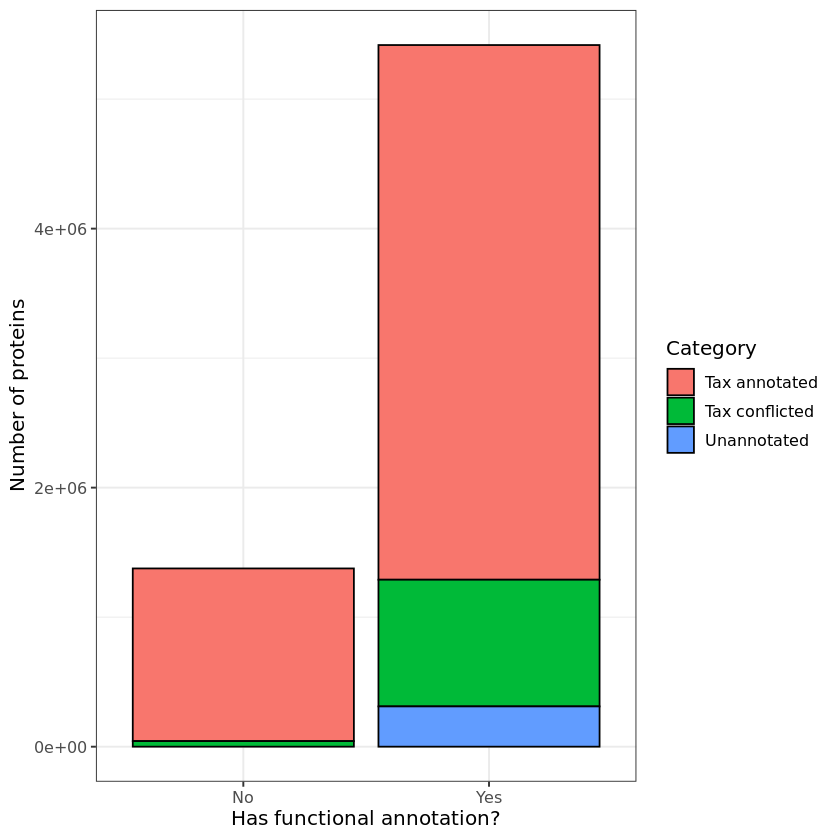

In [188]:
ggplot(consolidated_information %>% 
       dplyr::mutate(Category = case_when((HasHit=="Yes")&(HasConflict=="No")~ "Tax annotated",
                                          (HasHit=="Yes")&(HasConflict=="Yes") ~ "Tax conflicted",
                                          (HasHit=="No") ~ "Unannotated")) %>%
       dplyr::group_by(Category,HasFunctional) %>% dplyr::tally()) + 
    geom_bar(aes(x = HasFunctional, y = n, fill = Category),stat="identity",color="black") + 
    theme_bw(base_size=12) + ylab("Number of proteins") + xlab("Has functional annotation?")
ggsave("functional_taxonomic_breakdown_any_funct_annot.pdf")

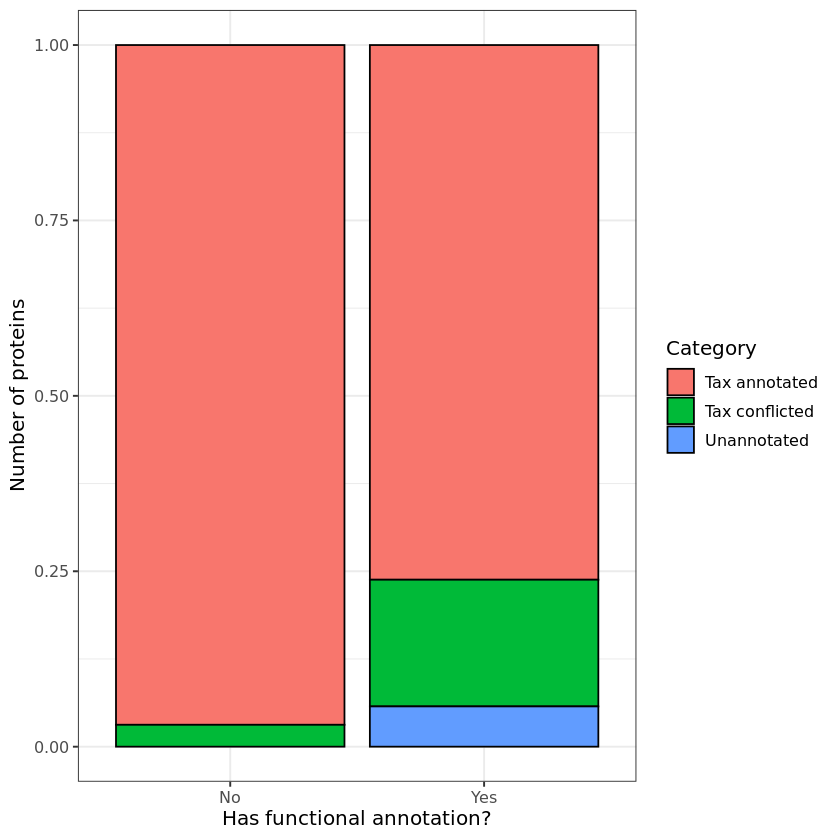

In [187]:
ggplot(consolidated_information %>% 
       dplyr::mutate(Category = case_when((HasHit=="Yes")&(HasConflict=="No")~ "Tax annotated",
                                          (HasHit=="Yes")&(HasConflict=="Yes") ~ "Tax conflicted",
                                          (HasHit=="No") ~ "Unannotated")) %>%
       dplyr::group_by(Category,HasFunctional) %>% dplyr::tally()) + 
    geom_bar(aes(x = HasFunctional, y = n, fill = Category),stat="identity",position="fill",color="black") + 
    theme_bw(base_size=12) + ylab("Number of proteins") + xlab("Has functional annotation?")

In [ ]:
radiolaria_eukulele = radiolaria_eukulele %>%
    tidyr::separate(full_classification,sep=";",into=c("Domain","Supergroup",
                                                        "Division","Class","Order","Family",
                                                        "Genus","Species")) %>%
    dplyr::select(transcript_name,Domain,Division,Class)

marmmetsp_eukulele = marmmetsp_eukulele %>%
    tidyr::separate(full_classification,sep=";",into=c("Domain","Supergroup",
                                                        "Division","Class","Order","Family",
                                                        "Genus","Species")) %>%
    dplyr::select(transcript_name,Domain,Division,Class)

### Create map of BATS samples

In [ ]:
BATS_coordinates = read.csv("bats_coordinates.csv")

In [ ]:
world_map <- map_data("world")

In [ ]:
group_max_coords = world_map %>% dplyr::group_by(group) %>% dplyr::summarize(max_long=max(long),
                                                          min_long=min(long),
                                                          max_lat=max(lat),
                                                          min_lat=min(lat)) %>%
    dplyr::filter((max_long < -10) & (min_long > -130) & (max_lat < 50) & (min_lat > 0))

In [ ]:
world_map_N_Atl = world_map %>% dplyr::filter(group %in% group_max_coords$group)

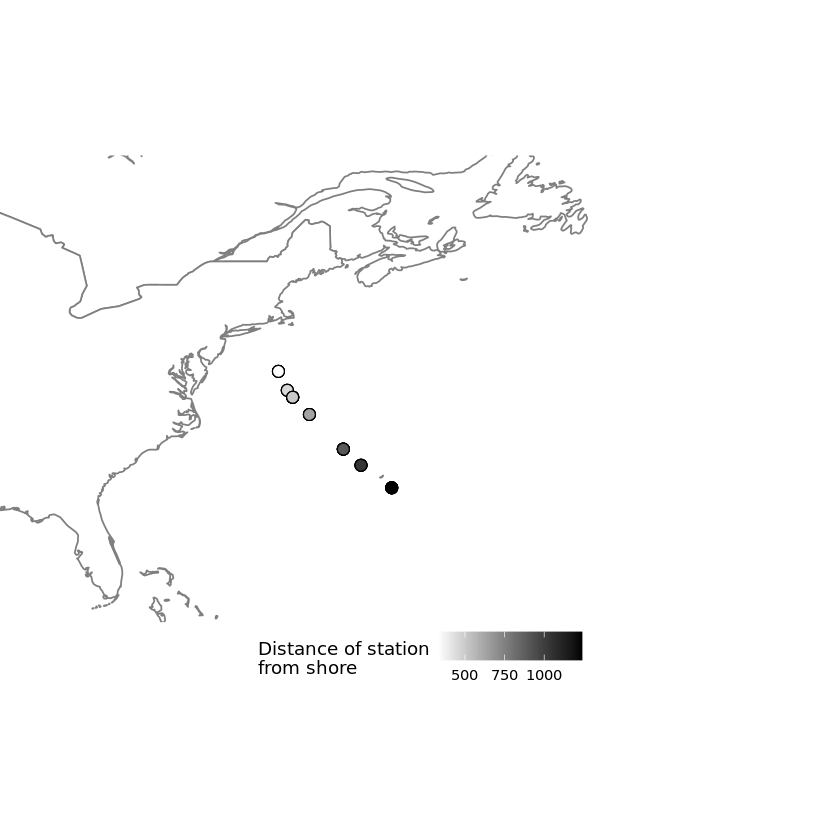

In [59]:
deg2rad <- function(deg) {
  return(deg * (pi/180))
}

calc_dist<-function(lat1,lon1,lat2,lon2){
    dLat = deg2rad(lat2-lat1)
    dLon = deg2rad(lon2-lon1)
    
    R = 6371
    a = sin(dLat/2) * sin(dLat/2) + cos(deg2rad(lat1)) * cos(deg2rad(lat2)) * 
            sin(dLon/2) * sin(dLon/2)
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = R * c;
    return(d) #acos(sin(lat1)*sin(lat2)+cos(lat1)*cos(lat2)*cos(lon2-lon1))*6371)
}

map_plot = ggplot() +
  geom_polygon(world_map, mapping=aes(long, lat, group = group), fill = "white", colour = "grey50") + 
  coord_sf(xlim = c(-85,-40), ylim = c(25,50)) + 
  geom_point(data = BATS_coordinates%>%dplyr::mutate(dist_from_whoi = calc_dist(Latitude,Longitude,41.5265,-70.6731)), 
             mapping=aes(x = Longitude, y = Latitude, fill = dist_from_whoi),pch=21,size=3)+
  theme_void() + theme(legend.position="bottom")+ 
  #scale_fill_manual(values=brewer.pal(7, "Set3"),name="Station")+
  scale_fill_gradient(low="white",high="black",name="Distance of station\nfrom shore",guide = "colourbar") #+
  #guides(fill=guide_legend(override.aes=list(shape=21,size=4)))
map_plot

### Select top Phyla for easy parsing

In [ ]:
top_divisions = unique(c((radiolaria_eukulele %>% dplyr::group_by(Division) %>% dplyr::tally() %>% 
    dplyr::filter(!is.na(Division)) %>%
    dplyr::slice_max(n, n=10))$Division,
                  (marmmetsp_eukulele %>% dplyr::group_by(Division) %>% dplyr::tally() %>% 
    dplyr::filter(!is.na(Division)) %>%
    dplyr::slice_max(n, n=10))$Division))

In [ ]:
## filter through sequences to retain labels for these top 10 Divisions so that we can pull their 
## abundances from Salmon and collapse all others

filtered_for_selection = ((radiolaria_eukulele %>% 
                          dplyr::mutate(Division=case_when(is.na(Division)~"Unannotated",
                                                         Division %in% top_divisions ~ Division,
                                                         TRUE ~ "Other")) %>%
    dplyr::rename(c("Rad_Division"="Division","Rad_Domain"="Domain","Rad_Class"="Class"))) %>%
    dplyr::left_join((marmmetsp_eukulele %>% dplyr::mutate(Division=case_when(is.na(Division)~"Unannotated",
                                                        Division %in% top_divisions ~ Division,
                                                         TRUE ~ "Other")) %>%
    dplyr::rename(c("Mar_Division"="Division","Mar_Domain"="Domain","Mar_Class"="Class"))))) %>%
    dplyr::mutate(Sequence = case_when((Rad_Division != "Other")|(Mar_Division != "Other") ~ transcript_name,
                                       TRUE ~ "Other")) %>%
    tidyr::separate(Sequence,sep="\\.",into=c("Sequence","ProteinID")) %>%
    dplyr::filter(Sequence != "Other")

In [ ]:
did_it_change = filtered_for_selection %>% 
                     dplyr::mutate(Mar_Division = case_when(is.na(Mar_Division) ~ "Unannotated",
                                                            TRUE ~ Mar_Division),
                                   Rad_Division = case_when(is.na(Rad_Division) ~ "Unannotated",
                                                            TRUE ~ Rad_Division))%>%
    dplyr::mutate(Changed=case_when(Rad_Division!=Mar_Division ~ "Changed phylum",
                                    TRUE ~ "Same phylum"))

In [ ]:
transcript_name_list = did_it_change %>%
                        tidyr::separate(transcript_name,sep="\\.p",
                                        into=c("transcript_name","protein_no"))

In [ ]:
salmon_dir = "/vortexfs1/omics/saito/BATS2019-clio-metaT/eukrhythmic_output/salmon_mega_merge/raw_individual"
salmon_files = list.files(salmon_dir)

all_salmon = data.frame()

for (salmon_file in salmon_files){
    if (grepl("quant",salmon_file)) {
        curr_file = data.frame(fread(file.path(salmon_dir,salmon_file,"quant.sf"),sep="\t"))
        curr_file["Sample"] = unlist(strsplit(salmon_file,"assembly_"))[2]
        curr_file = curr_file %>% dplyr::select(Name,TPM,NumReads,Sample) %>%
            dplyr::left_join(transcript_name_list,by=c("Name"="transcript_name")) %>%
            tidyr::replace_na(list("Domain"="Unannotated","Division"="Unannotated",
                            "Class"="Unannotated","Changed"="Unannotated")) %>% 
            dplyr::group_by(Mar_Domain,Mar_Division,Rad_Division,Changed,Sample)%>%
            dplyr::summarize(TPM=sum(TPM,na.rm=TRUE),NumReads=sum(NumReads,na.rm=TRUE))
        print(head(curr_file))
        all_salmon = all_salmon %>% dplyr::bind_rows(curr_file)
    }
}

In [45]:
BATS_coordinates

Latitude,Longitude,Sample,Station,Depth
<dbl>,<dbl>,<chr>,<int>,<int>
31.66689,-64.16629,HN001,1,30
31.66689,-64.16629,HN002,1,115
31.66689,-64.16629,HN003,1,200
31.66689,-64.16629,HN004,1,400
31.66689,-64.16629,HN005,1,800
32.99507,-65.97685,HN006,2,20
32.99507,-65.97685,HN007,2,120
32.99507,-65.97685,HN008,2,200
32.99507,-65.97685,HN009,2,400


In [ ]:
for_plot_salmon_bats = all_salmon %>% dplyr::group_by(Changed,Sample) %>% dplyr::summarize(TPMchanged=sum(TPM)) %>%
             dplyr::filter(Changed!="Unannotated")

In [ ]:
rm(all_salmon)

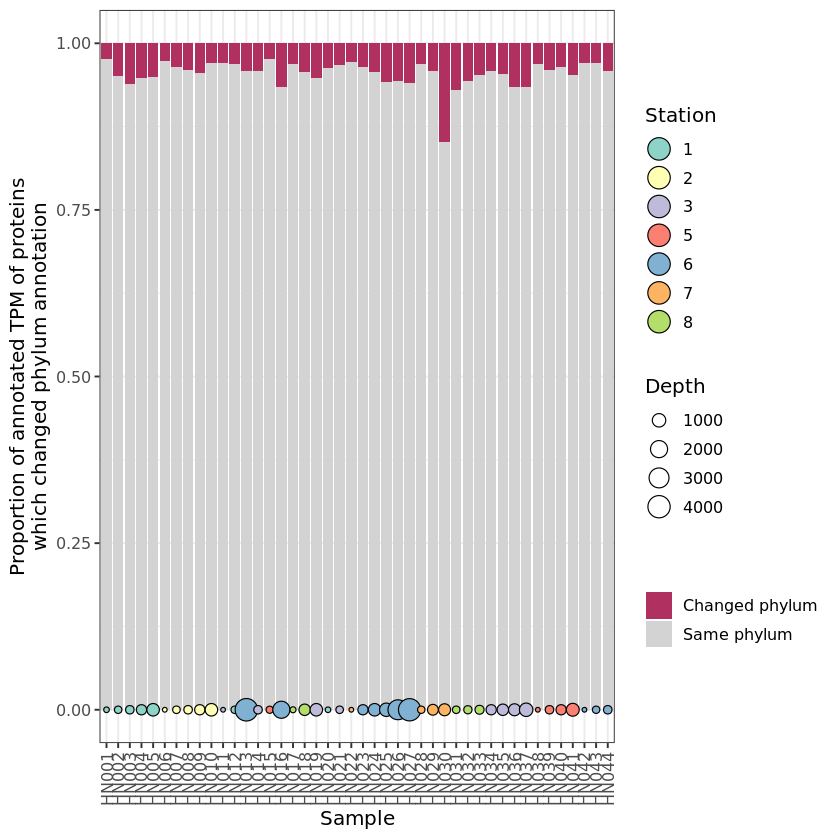

In [157]:
changed_tpm_plot = ggplot()+
    geom_bar(for_plot_salmon_bats,
             mapping=aes(x=Sample,y=TPMchanged,fill=Changed),stat="identity",position="fill")+
    scale_fill_manual(values=c("maroon","light grey"),name="") + 
    new_scale_fill()+
    geom_point(BATS_coordinates,mapping=aes(x = Sample,fill=factor(Station),size=Depth),pch=21,y=0)+
    scale_fill_manual(values=brewer.pal(9, "Set3"),name="Station")+
    ylab("Proportion of annotated TPM of proteins\nwhich changed phylum annotation")+theme_bw(base_size=12)+
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+
    guides(fill=guide_legend(override.aes=list(shape=21,size=6)))
changed_tpm_plot

In [179]:
unique(BATS_coordinates$Depth)

[1]   30  115  200  400  800   20  120 4100  100 2000   40  600 1000 3000 4000
[16]  108  500  700  175  250  880  110

In [47]:
BATS_coordinates

Latitude,Longitude,Sample,Station,Depth
<dbl>,<dbl>,<chr>,<int>,<int>
31.66689,-64.16629,HN001,1,30
31.66689,-64.16629,HN002,1,115
31.66689,-64.16629,HN003,1,200
31.66689,-64.16629,HN004,1,400
31.66689,-64.16629,HN005,1,800
32.99507,-65.97685,HN006,2,20
32.99507,-65.97685,HN007,2,120
32.99507,-65.97685,HN008,2,200
32.99507,-65.97685,HN009,2,400


Joining, by = "Sample"


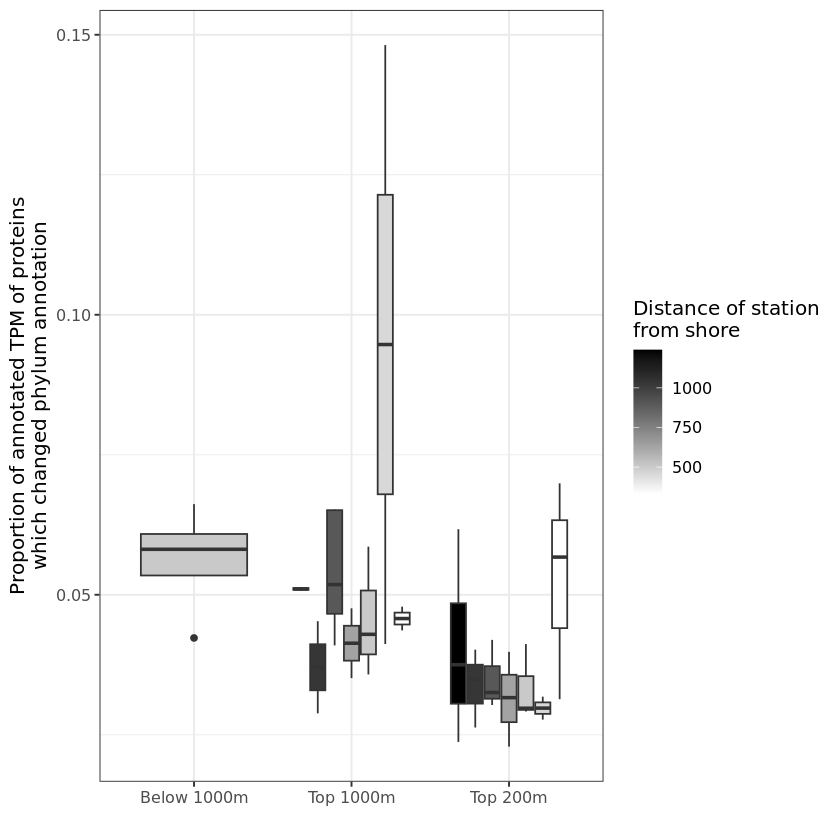

In [64]:
deg2rad <- function(deg) {
  return(deg * (pi/180))
}

calc_dist<-function(lat1,lon1,lat2,lon2){
    dLat = deg2rad(lat2-lat1)
    dLon = deg2rad(lon2-lon1)
    
    R = 6371
    a = sin(dLat/2) * sin(dLat/2) + cos(deg2rad(lat1)) * cos(deg2rad(lat2)) * 
            sin(dLon/2) * sin(dLon/2)
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = R * c;
    return(d) #acos(sin(lat1)*sin(lat2)+cos(lat1)*cos(lat2)*cos(lon2-lon1))*6371)
}

changed_tpm_boxplot = ggplot(for_plot_salmon_bats %>% tidyr::pivot_wider(id_cols ="Sample", 
                                                                         names_from="Changed", values_from="TPMchanged") %>%
    dplyr::rename("Samephylum"="Same phylum","Changedphylum"="Changed phylum") %>%
    dplyr::mutate(propChanged = Changedphylum/(Changedphylum+Samephylum)) %>%
    dplyr::left_join(BATS_coordinates) %>%
    dplyr::mutate(depthCat = case_when(Depth<=200 ~ "Top 200m",
                                       Depth<=1000 ~ "Top 1000m",
                                       Depth>1000 ~ "Below 1000m")) %>% #41.5265° N, 70.6731° W
    dplyr::mutate(dist_from_whoi = calc_dist(Latitude,Longitude,41.5265,-70.6731))) + 
    geom_boxplot(aes(x = depthCat, y = propChanged,
                     fill = dist_from_whoi, 
                     group = paste0(Station,depthCat)))+
    #scale_fill_manual(values=brewer.pal(9, "Set3"),name="Station")+
    scale_fill_gradient(low="white",high="black",name="Distance of station\nfrom shore")+
    ylab("Proportion of annotated TPM of proteins\nwhich changed phylum annotation")+
    theme_bw(base_size=12)+xlab("")#+
    #guides(fill=guide_legend(override.aes=list(shape=21,size=6))) + xlab("")
changed_tpm_boxplot

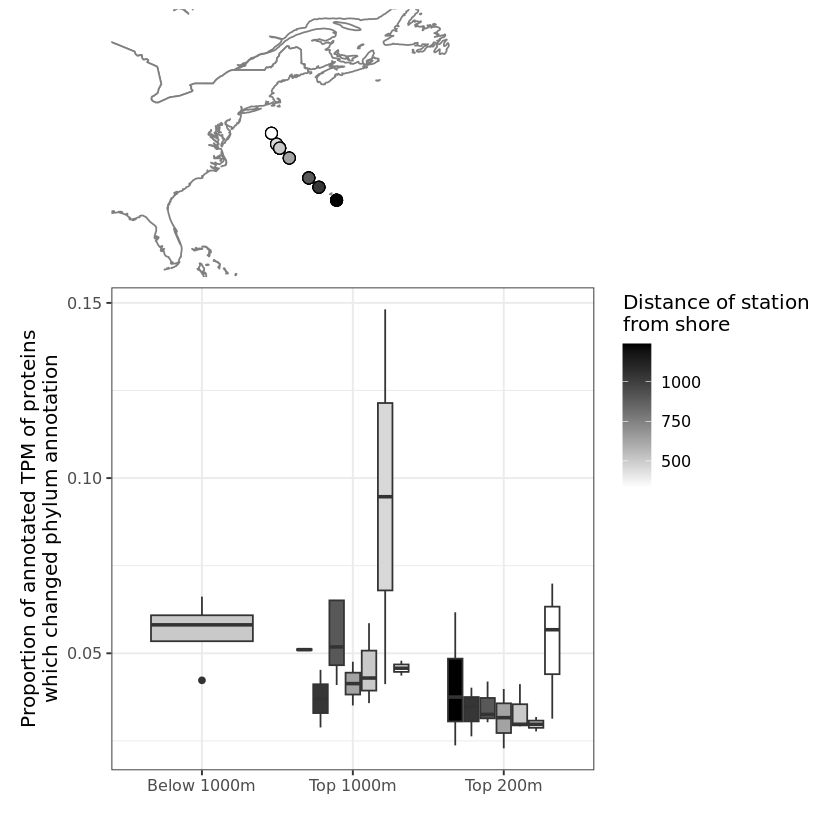

In [65]:
(map_plot+theme(legend.position="none")) / changed_tpm_boxplot+ plot_layout(guides = "collect")

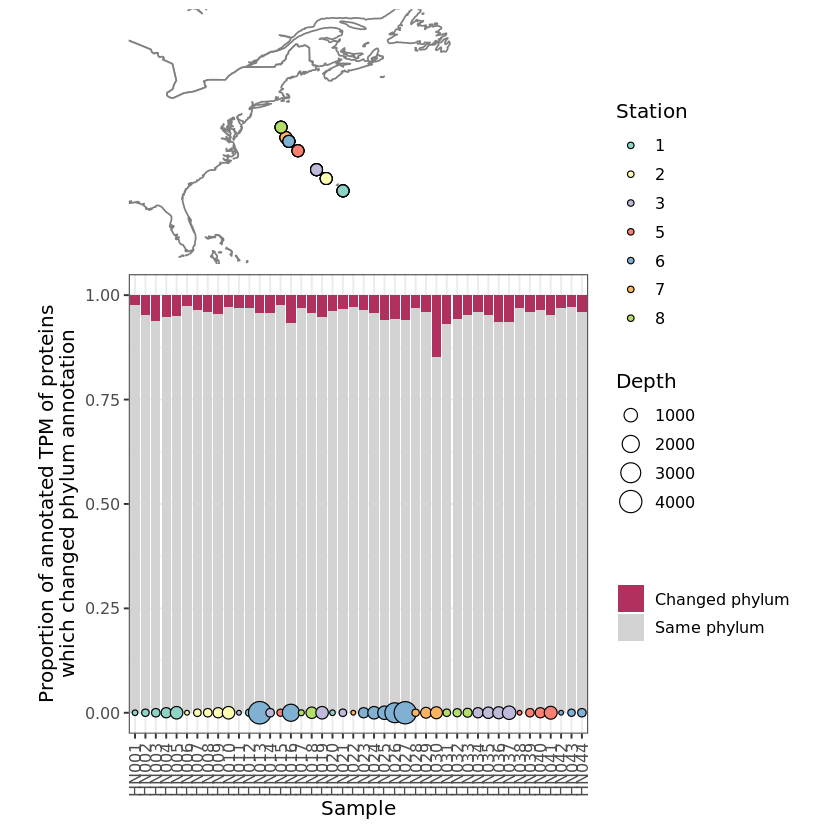

In [113]:
(map_plot+theme(legend.position="none")) / changed_tpm_plot+ plot_layout(guides = "collect")

### we need to quickly grab IDs of the sequences that changed annotations when we added Radiolarians. We'll take the Salmon TPM of those sequences and assign the balance of TPM to be unchanged annotations.



In [235]:
as.data.frame(filtered_for_selection %>% 
                     dplyr::mutate(Mar_Division = case_when(is.na(Mar_Division) ~ "Unannotated",
                                                            TRUE ~ Mar_Division)) %>%
                     dplyr::group_by(Mar_Domain,Rad_Division,Mar_Division) %>%
                     dplyr::tally() %>%
                     dplyr::mutate(Mar_Domain = case_when((Mar_Domain=="")|(is.na(Mar_Domain)) ~ "Unannotated",
                                                          TRUE ~ Mar_Domain))) %>%
    dplyr::mutate(Changed=case_when(Rad_Division!=Mar_Division ~ "Changed phylum",
                                    TRUE ~ "Same phylum"))

Mar_Domain,Rad_Division,Mar_Division,n,Changed
<chr>,<chr>,<chr>,<int>,<chr>
Unannotated,Alphaproteobacteria,Unannotated,7,Changed phylum
Unannotated,Bacteroidetes/Chlorobi group,Unannotated,2,Changed phylum
Unannotated,Cyanobacteria,Unannotated,7,Changed phylum
Unannotated,Dinoflagellata,Unannotated,2,Changed phylum
Unannotated,Gammaproteobacteria,Unannotated,14,Changed phylum
Unannotated,Haptophyta,Unannotated,1,Changed phylum
Unannotated,Retaria,Unannotated,1454,Changed phylum
Unannotated,Other,Unannotated,6,Changed phylum
Unannotated,Unannotated,Unannotated,163958,Same phylum


`summarise()` has grouped
output by 'Mar_Division'. You
can override using the
`.groups` argument.


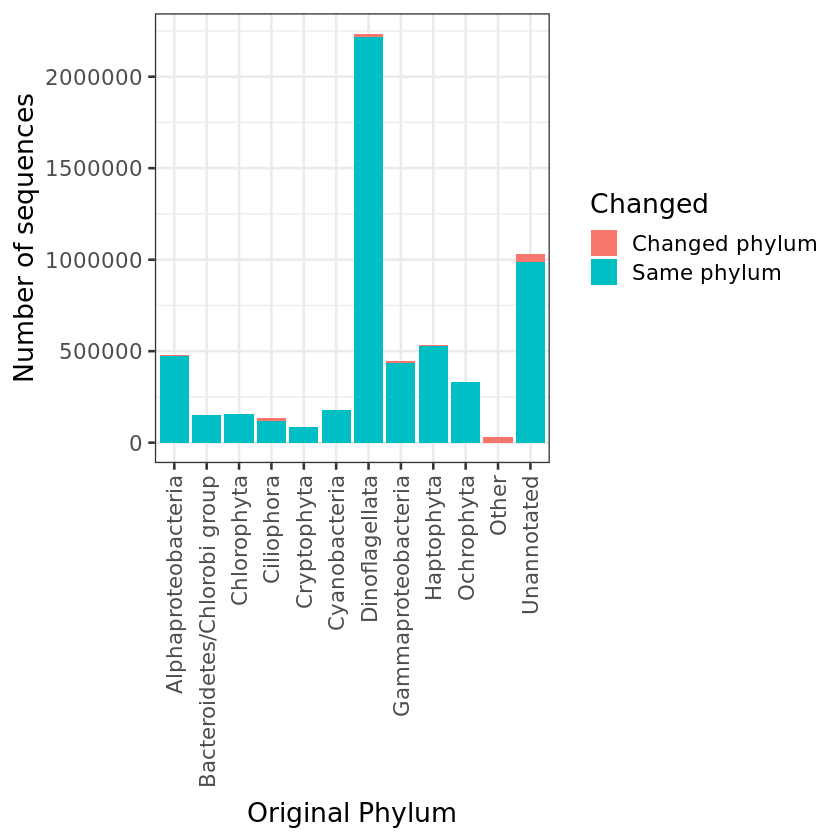

In [242]:
## compare those that change vs. remain same annotation in BATS
ggplot(as.data.frame(filtered_for_selection %>% 
                     dplyr::mutate(Mar_Division = case_when(is.na(Mar_Division) ~ "Unannotated",
                                                            TRUE ~ Mar_Division)) %>%
                     dplyr::group_by(Mar_Domain,Rad_Division,Mar_Division) %>%
                     dplyr::tally() %>%
                     dplyr::mutate(Mar_Domain = case_when((Mar_Domain=="")|(is.na(Mar_Domain)) ~ "Unannotated",
                                                          TRUE ~ Mar_Domain))) %>%
    dplyr::mutate(Changed=case_when(Rad_Division!=Mar_Division ~ "Changed phylum",
                                    TRUE ~ "Same phylum")) %>%
    dplyr::group_by(Mar_Division,Changed) %>% dplyr::summarize(n=sum(n))) + 
    geom_bar(aes(x = Mar_Division, y = n, fill = Changed),stat='identity') + theme_bw(base_size=16) + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
    xlab("Original Phylum") + ylab("Number of sequences")

Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Saving 6.67 x 6.67 in image
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”


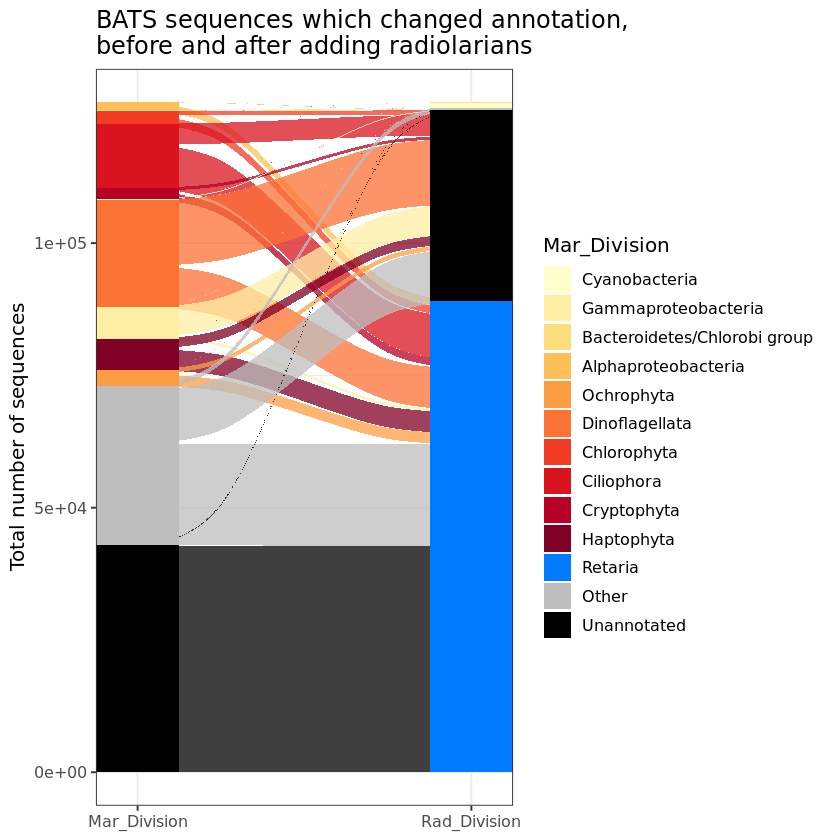

In [93]:
## alluvial plot!

colorct=12
alluvial_data = (as.data.frame(filtered_for_selection %>% 
                     dplyr::mutate(Mar_Division = case_when(is.na(Mar_Division) ~ "Unannotated",
                                                            TRUE ~ Mar_Division)) %>%
                     dplyr::group_by(Mar_Domain,Rad_Division,Mar_Division) %>%
                     dplyr::tally() %>%
                     dplyr::mutate(Mar_Domain = case_when((Mar_Domain=="")|(is.na(Mar_Domain)) ~ "Unannotated",
                                                          TRUE ~ Mar_Domain))) %>%
                 dplyr::filter(Rad_Division!=Mar_Division)) %>%
                 dplyr::mutate(Rad_Division=trimws(Rad_Division),Mar_Division=trimws(Mar_Division))#grepl("Retaria",Rad_Division)))
alluvial_plot = ggplot(alluvial_data,
       aes(y = n, axis1 = Mar_Division, axis2 = Rad_Division)) +
  geom_alluvium(aes(fill = Mar_Division), width = 1/12, alpha=0.75) +
  geom_stratum(aes(fill = after_stat(stratum)),color="transparent",width = 1/4)  +
  #geom_label(stat = "stratum", aes(label = after_stat(stratum), fill = after_stat(stratum))) +
  #geom_text(stat = "stratum", aes(label = after_stat(stratum))) +
  scale_x_discrete(limits = c("Mar_Division", "Rad_Division"), expand = c(.05, .05)) +
  #scale_fill_brewer(type = "qual", palette = "Set3",name = "MarMMETSP\nDomain") + 
  #scale_fill_manual(values = c(colorRampPalette(brewer.pal(12, "Set3"))(colorct),"dark gray"),
  #                 name = "Phylum") +
  scale_fill_manual(values=c(colorRampPalette(brewer.pal(9, 'YlOrRd'))(colorct-2),"#007AFF","gray","black"),
                    breaks=c(setdiff(c(unique(alluvial_data$Mar_Division),
                                       unique(alluvial_data$Rad_Division)),
                                    c("Retaria","Other","Unannotated")),c("Retaria","Other","Unannotated"))) + 
  theme_bw(base_size=12) +
  ylab("Total number of sequences") +
  ggtitle("BATS sequences which changed annotation,\nbefore and after adding radiolarians")
alluvial_plot

ggsave("alluvial_plot_for_ms.pdf")

In [80]:
c(setdiff(c(unique(alluvial_data$Mar_Division),
            unique(alluvial_data$Rad_Division)),
                                    c("Retaria","Other","Unannotated")))

[1] "Cyanobacteria"                "Gammaproteobacteria"         
 [3] "Bacteroidetes/Chlorobi group" "Alphaproteobacteria"         
 [5] "Ochrophyta"                   "Dinoflagellata"              
 [7] "Chlorophyta"                  "Ciliophora"                  
 [9] "Cryptophyta"                  "Haptophyta"

## Read in DeepClust results in order to make UpSeT and ridge plots

## we needed to edit this in order to get the sequences that are radiolarian using protein BLAST rather than blastx.

```
cat /vortexfs1/omics/alexander/akrinos/2022-euk-diversity/code/snakemake-workflows/diamond-deepclust/bats-clustering/bats-eukulele-workflow/bats-eukulele-workflow/radiolaria_search/taxonomy_estimation/merged.fasta.transdecoder-estimated-taxonomy.out  | grep Radiolaria  > radiolaria_eukzoo_eukulele_protein.out
```

In [ ]:
radio_frame=read.csv("/vortexfs1/omics/alexander/akrinos/2022-euk-diversity/code/snakemake-workflows/diamond-deepclust/bats-clustering/radiolaria_eukzoo_eukulele_protein.out",
                     sep="\t",header=FALSE, col.names = c("xtra","transcript_name","max_level","full_classification",
                                                         "best_classification","best_bitscore","extra","uncertain"))

In [ ]:
radio_clusts_w_rad=read.csv("/vortexfs1/omics/alexander/akrinos/2022-euk-diversity/code/snakemake-workflows/diamond-deepclust/bats-clustering/bats-workflow/mmetsp_radiolaria_deepclust.mad.20.out",
                         sep="\t",header=FALSE,col.names=c("Rep","Mem"))
radio_clusts_w_rad = radio_clusts_w_rad #%>%
    #tidyr::separate("Mem",sep="\\.p",into=c("nt_id","prot_no"))
## get members of the clusters that contain radiolarians
radio_filt_w_rad=radio_clusts_w_rad %>% dplyr::inner_join(radio_frame,by=c("Mem"="transcript_name"))

In [ ]:
## now get everything present in those clusters, radiolarian or not
full_clusters_filt_w_rad = radio_clusts_w_rad %>% dplyr::select(Rep,Mem) %>%
    dplyr::filter(Rep %in% radio_filt_w_rad$Rep) %>%
    #dplyr::inner_join(radio_filt_w_rad %>% dplyr::select(Rep),by=c("Rep")) %>%
    dplyr::mutate(type_in = case_when(grepl("CAMPEP",Mem)|grepl("MMP",Mem) ~ "MarMMETSP",
                                      grepl("HN",Mem) ~ "BATS",
                                      TRUE ~ "Radiolarian")) %>% dplyr::ungroup()

In [ ]:
makeset <- function(input_list) {
    return(paste(sort(unique(input_list)),collapse="_"))
}

sorted_types_w_rad = full_clusters_filt_w_rad %>%
    dplyr::group_by(Rep) %>%
    dplyr::summarize(collapsed=makeset(type_in)) %>%
    dplyr::arrange(collapsed)

sorted_types_w_rad_2=sorted_types_w_rad %>% dplyr::select(Rep,collapsed) %>%
    dplyr::inner_join(full_clusters_filt_w_rad %>% dplyr::select(Rep,Mem) %>% dplyr::distinct(),
                      by = "Rep") %>%  # restore members to cluster
    dplyr::filter(Mem %in% radio_filt_w_rad$Mem) %>% # just get the cluster members that are Radiolarian-predicted.
    #dplyr::left_join(radio_frame %>% dplyr::select(transcript_name),
    #                 by = c("Mem"="transcript_name")) %>%
    dplyr::distinct()
rad_frame = sorted_types_w_rad_2 %>% dplyr::distinct(Rep,collapsed,.keep_all=TRUE) %>%
    dplyr::group_by(collapsed) %>% dplyr::tally()

rad_frame["Type"] = "NumberClusters"
rad_frame = rad_frame %>%
    dplyr::bind_rows(sorted_types_w_rad_2 %>% dplyr::distinct(Rep,Mem,collapsed,.keep_all=TRUE) %>%
    dplyr::group_by(collapsed) %>% dplyr::tally() %>% dplyr::mutate(Type="NumberSequences"))

In [ ]:
sorted_types_w_rad_all = sorted_types_w_rad %>% dplyr::select(Rep,collapsed) %>%
    dplyr::inner_join(full_clusters_filt_w_rad %>% dplyr::select(Rep,Mem) %>% dplyr::distinct(),
                      by = "Rep") %>%  # restore members to cluster
    dplyr::distinct() %>% dplyr::group_by(Rep,collapsed) %>% dplyr::tally()

In [125]:
sorted_types_w_rad_2 %>% dplyr::distinct(Rep,Mem,collapsed,.keep_all=TRUE) %>%
    dplyr::group_by(collapsed) %>% dplyr::tally()

collapsed,n
<chr>,<int>
BATS,5246
BATS_MarMMETSP,5168
BATS_MarMMETSP_Radiolarian,65641
BATS_Radiolarian,11967


In [42]:
sorted_types_w_rad_2 %>% dplyr::distinct(Rep,Mem,collapsed,.keep_all=TRUE) %>%
    dplyr::group_by(collapsed) %>% dplyr::tally()

collapsed,n
<chr>,<int>
BATS,5246
BATS_MarMMETSP,5168
BATS_MarMMETSP_Radiolarian,65641
BATS_Radiolarian,11967


In [89]:
sum((sorted_types_w_rad_2 %>% dplyr::distinct(Rep,collapsed,.keep_all=TRUE) %>%
    dplyr::group_by(collapsed) %>% dplyr::tally())$n)

[1] 7127

In [90]:
sum((sorted_types_w_rad_2 %>% dplyr::distinct(Rep,Mem,collapsed,.keep_all=TRUE) %>%
    dplyr::group_by(collapsed) %>% dplyr::tally())$n)

[1] 88022

### Same thing, but with clustering on the MMETSP + BATS seqs only.

In [2]:
radio_clusts=read.csv("/vortexfs1/omics/alexander/akrinos/2022-euk-diversity/code/snakemake-workflows/diamond-deepclust/bats-clustering/bats-workflow/mmetsp_deepclust.mad.20.out",
                         sep="\t",header=FALSE,col.names=c("Rep","Mem"))
radio_filt=radio_clusts %>% dplyr::inner_join(radio_frame,by=c("Mem"="transcript_name"))

ERROR: Error in is.data.frame(y): object 'radio_frame' not found


In [ ]:
nrow(radio_filt)

In [ ]:
## now get everything present in those clusters, radiolarian or not
full_clusters_filt = radio_clusts %>% dplyr::select(Rep,Mem) %>%
    dplyr::filter(Rep %in% radio_filt$Rep) %>%
    dplyr::mutate(type_in = case_when(grepl("CAMPEP",Mem)|grepl("MMP",Mem) ~ "MarMMETSP",
                                      grepl("HN",Mem) ~ "BATS",
                                      TRUE ~ "Radiolarian-BAD"))

In [ ]:
head(full_clusters_filt)

In [ ]:
makeset <- function(input_list) {
    return(paste(sort(unique(input_list)),collapse="_"))
}

sorted_types = full_clusters_filt %>%
    dplyr::group_by(Rep) %>%
    dplyr::summarize(collapsed=makeset(type_in)) %>%
    dplyr::arrange(collapsed)

sorted_types_2=sorted_types %>% dplyr::select(Rep,collapsed) %>%
    dplyr::inner_join(full_clusters_filt %>% dplyr::select(Rep,Mem) %>% dplyr::distinct(),
                      by = "Rep") %>%  # restore members to cluster
    dplyr::filter(Mem %in% radio_filt$Mem) %>% # just get the cluster members that are Radiolarian-predicted.
    #dplyr::left_join(radio_frame %>% dplyr::select(transcript_name),
    #                 by = c("Mem"="transcript_name")) %>%
    dplyr::distinct()
mmetsp_frame = sorted_types_2 %>% dplyr::distinct(Rep,collapsed,.keep_all=TRUE) %>%
    dplyr::group_by(collapsed) %>% dplyr::tally()

mmetsp_frame["Type"] = "NumberClusters"
mmetsp_frame = mmetsp_frame %>%
    dplyr::bind_rows(sorted_types_2 %>% dplyr::distinct(Rep,Mem,collapsed,.keep_all=TRUE) %>%
    dplyr::group_by(collapsed) %>% dplyr::tally() %>% dplyr::mutate(Type="NumberSequences"))

In [ ]:
sorted_types_all = sorted_types %>% dplyr::select(Rep,collapsed) %>%
    dplyr::inner_join(full_clusters_filt %>% dplyr::select(Rep,Mem) %>% dplyr::distinct(),
                      by = "Rep") %>%  # restore members to cluster
    dplyr::distinct() %>% dplyr::group_by(Rep,collapsed) %>% dplyr::tally()

Warning message in brewer.pal(2, "Set3"):
“minimal value for n is 3, returning requested palette with 3 different levels
”
Picking joint bandwidth of 0.127

Saving 6.67 x 6.67 in image
Picking joint bandwidth of 0.127

Saving 6.67 x 6.67 in image
Picking joint bandwidth of 0.127



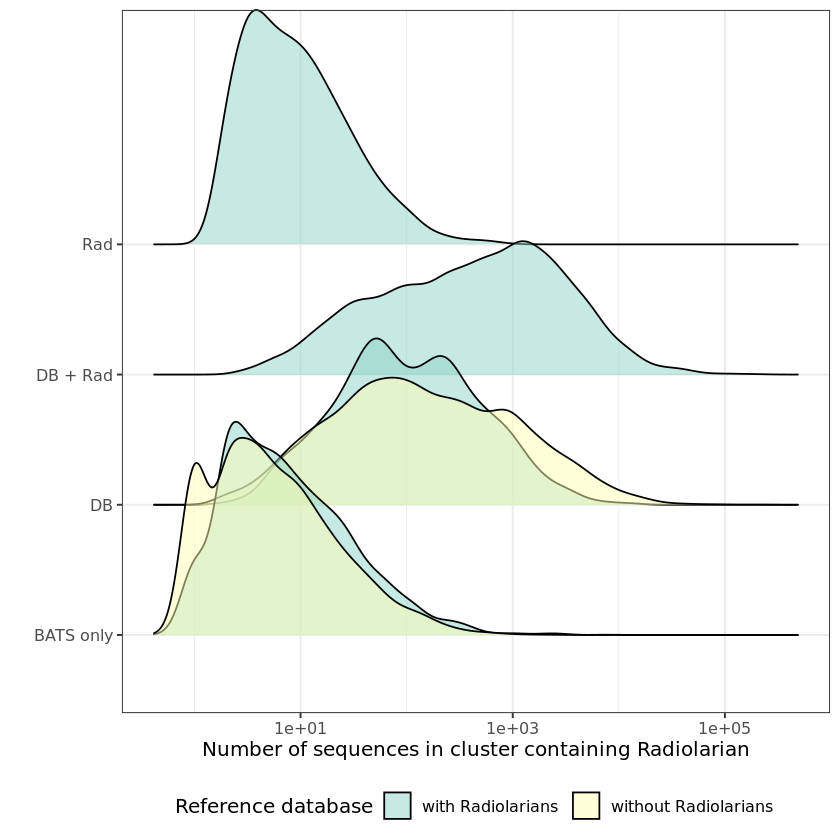

In [164]:
ridges_plot = ggplot(sorted_types_all %>% dplyr::mutate(Character="without Radiolarians") %>%
       dplyr::bind_rows(sorted_types_w_rad_all %>% dplyr::mutate(Character="with Radiolarians")) %>%
       dplyr::mutate(collapsed=case_when(collapsed=="BATS_MarMMETSP_Radiolarian"~"DB + Rad",
                                         collapsed=="BATS_Radiolarian" ~ "Rad",
                                         collapsed=="BATS_MarMMETSP" ~ "DB",
                                         collapsed=="BATS" ~ "BATS only"))) + 
    geom_density_ridges(aes(x = n, y = collapsed, fill = Character,
                            group=paste0(collapsed,Character)),alpha=0.5) + scale_x_log10() + 
    theme_bw(base_size=12) + xlab("Number of sequences in cluster containing Radiolarian") + 
    ylab("")+scale_fill_manual(values=brewer.pal(2, "Set3"),name="Reference database") + 
    theme(legend.position="bottom")
ridges_plot
ggsave("ridgeplot_cluster_size.pdf")
ggsave("ridgeplot_cluster_size.png")

In [160]:
rad_frame %>% dplyr::mutate(list_collapsed=lapply(lapply(collapsed,strsplit,"_"),unlist)) %>%
       dplyr::mutate(Character="with Radiolaria") %>%
       dplyr::bind_rows(mmetsp_frame %>% dplyr::mutate(list_collapsed=lapply(lapply(collapsed,
                                                                                    strsplit,"_"),unlist)) %>%
                        dplyr::mutate(Character="without Radiolaria")) %>% 
    dplyr::group_by(Character,Type) %>% dplyr::summarize(n=sum(n))

`summarise()` has grouped
output by 'Character'. You can
override using the `.groups`
argument.


Character,Type,n
<chr>,<chr>,<int>
with Radiolaria,NumberClusters,7127
with Radiolaria,NumberSequences,88022
without Radiolaria,NumberClusters,9548
without Radiolaria,NumberSequences,88022


In [161]:
rad_frame

collapsed,n,Type
<chr>,<int>,<chr>
BATS,1640,NumberClusters
BATS_MarMMETSP,1264,NumberClusters
BATS_MarMMETSP_Radiolarian,2717,NumberClusters
BATS_Radiolarian,1506,NumberClusters
BATS,5246,NumberSequences
BATS_MarMMETSP,5168,NumberSequences
BATS_MarMMETSP_Radiolarian,65641,NumberSequences
BATS_Radiolarian,11967,NumberSequences


In [162]:
rad_frame %>% dplyr::mutate(list_collapsed=lapply(lapply(collapsed,strsplit,"_"),unlist)) %>%
       dplyr::mutate(Character="with Radiolaria") %>%
       dplyr::bind_rows(mmetsp_frame %>% dplyr::mutate(list_collapsed=lapply(lapply(collapsed,
                                                                                    strsplit,"_"),unlist)) %>%
                        dplyr::mutate(Character="without Radiolaria")) %>% 
    dplyr::group_by(Character,collapsed,Type) %>% dplyr::summarize(n=sum(n)) %>%
    dplyr::arrange(Type,collapsed,Character)

`summarise()` has grouped
output by 'Character',
'collapsed'. You can override
using the `.groups` argument.


Character,collapsed,Type,n
<chr>,<chr>,<chr>,<int>
with Radiolaria,BATS,NumberClusters,1640
without Radiolaria,BATS,NumberClusters,3968
with Radiolaria,BATS_MarMMETSP,NumberClusters,1264
without Radiolaria,BATS_MarMMETSP,NumberClusters,5580
with Radiolaria,BATS_MarMMETSP_Radiolarian,NumberClusters,2717
with Radiolaria,BATS_Radiolarian,NumberClusters,1506
with Radiolaria,BATS,NumberSequences,5246
without Radiolaria,BATS,NumberSequences,20900
with Radiolaria,BATS_MarMMETSP,NumberSequences,5168


Saving 6.67 x 6.67 in image


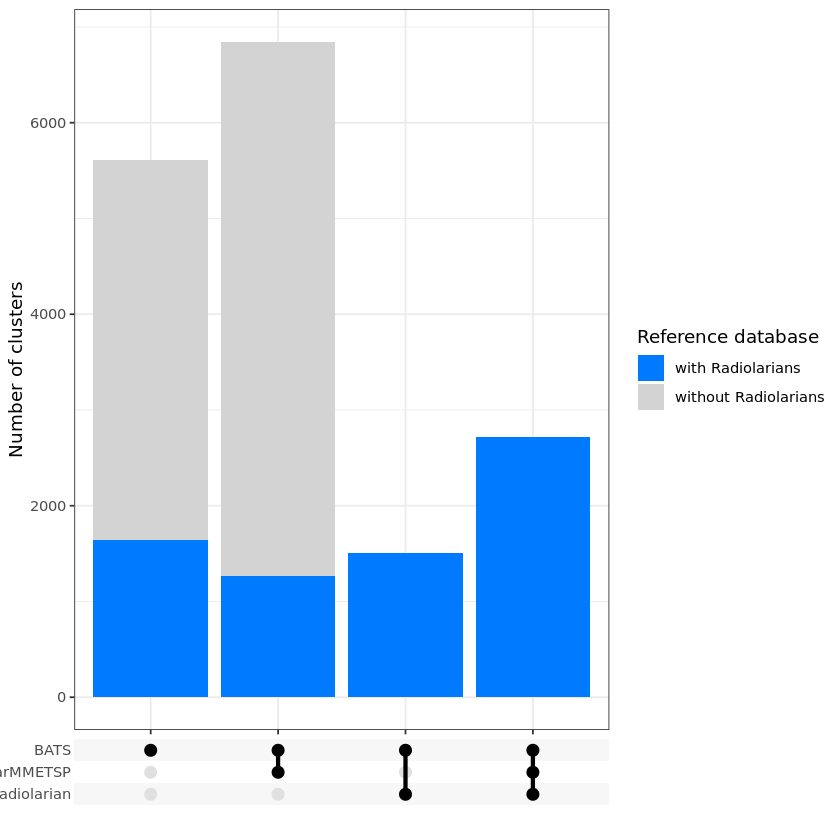

In [94]:
upset_plot = ggplot(rad_frame %>% dplyr::mutate(list_collapsed=lapply(lapply(collapsed,strsplit,"_"),unlist)) %>%
       dplyr::mutate(Character="with Radiolarians") %>%
       dplyr::bind_rows(mmetsp_frame %>% dplyr::mutate(list_collapsed=lapply(lapply(collapsed,
                                                                                    strsplit,"_"),unlist)) %>%
                        dplyr::mutate(Character="without Radiolarians")) %>%
       dplyr::filter(Type=="NumberClusters")) +
    geom_bar(aes(x = list_collapsed, y = n, fill = Character, group = paste0(Type,collapsed)),stat="identity",
             position="stack") +
    scale_x_upset(order_by="degree",n_intersections = 40)+ylab("Number of clusters")+
    theme_bw() +scale_fill_manual(values=c("#007AFF","light gray"),breaks=c("with Radiolarians",
                                                                            "without Radiolarians"),
                                  name="Reference database") +xlab("")# + 
    #theme(legend.position="bottom")#+ facet_wrap(~Type,nrow=2,scales="free_y")

upset_plot
ggsave("upsetplot_radiolarian_clusters.pdf")


In [63]:
sum((sorted_types_2 %>% dplyr::distinct(Rep,Mem,collapsed,.keep_all=TRUE) %>%
    dplyr::group_by(collapsed) %>% dplyr::tally())$n)

[1] 88022

In [64]:
sorted_types_2 %>% dplyr::distinct(Rep,.keep_all=T) %>%
    dplyr::group_by(collapsed) %>% dplyr::tally() 

collapsed,n
<chr>,<int>
BATS,3968
MarMMETSP_BATS,5580


Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”


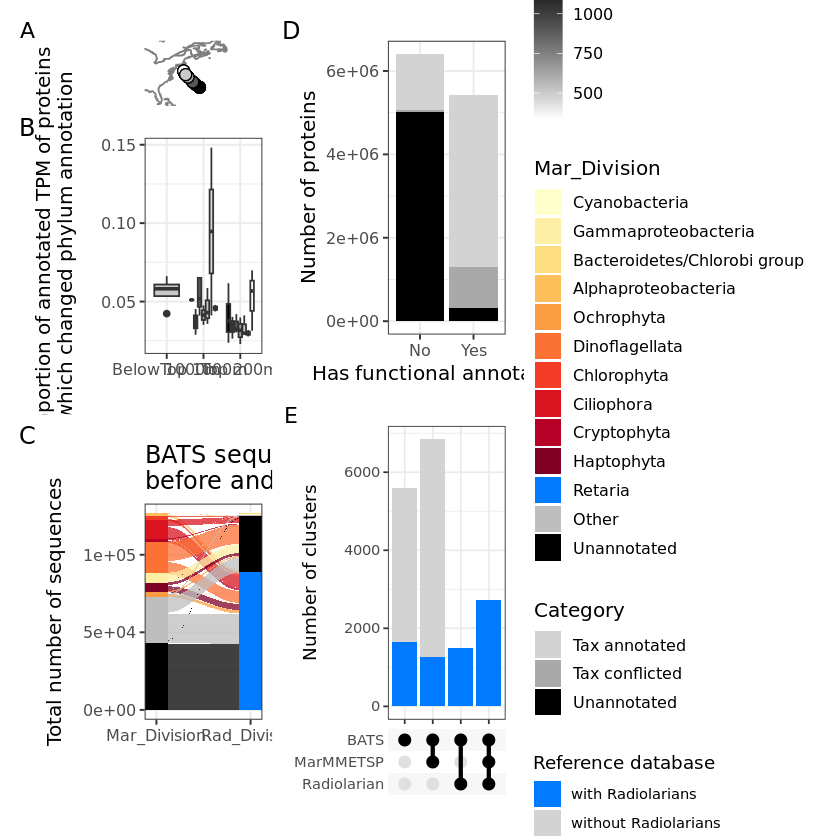

In [95]:
((((map_plot+theme(legend.position="none")) / changed_tpm_boxplot) / alluvial_plot) | (funct_plot/(upset_plot)))+ plot_annotation(tag_levels = "A")+ 
  plot_layout(widths = c(1,1), heights = c(1,1), guides="collect")
ggsave("plot_facetted_new.pdf",width=11,height=11,units="in")

Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”


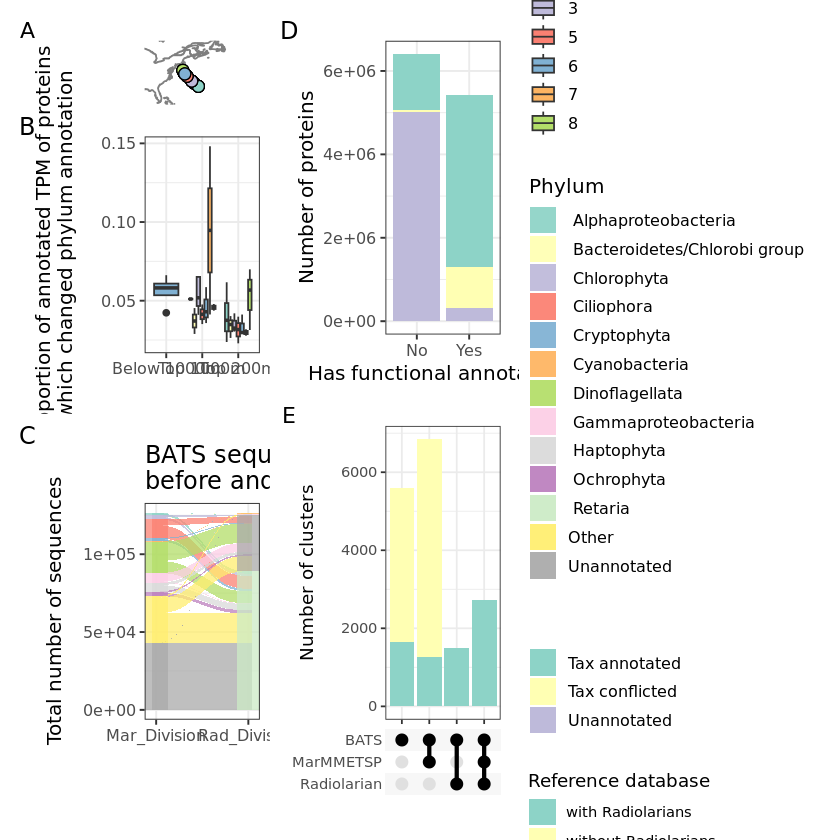

In [187]:
((((map_plot+theme(legend.position="none")) / changed_tpm_boxplot) / alluvial_plot) | (funct_plot/(upset_plot)))+ plot_annotation(tag_levels = "A")+ 
  plot_layout(widths = c(1,1), heights = c(1,1), guides="collect")
ggsave("plot_facetted_new.pdf",width=11,height=11,units="in")

In [143]:
(alluvial_plot / funct_plot) | ((upset_plot+theme(legend.position="none")) / ridges_plot)+ plot_annotation(tag_levels = "A")+ 
  plot_layout(widths = c(1,1), heights = c(1,1))
ggsave("plot_facetted.pdf",width=10,height=10,units="in")

ERROR: Error in eval(expr, envir, enclos): object 'ridges_plot' not found


### Supplemental figures: EUKulele mapping on CDSs vs. on contigs

In [3]:
radiolaria_eukulele = data.frame(fread("/vortexfs1/omics/alexander/akrinos/2022-euk-diversity/code/snakemake-workflows/diamond-deepclust/bats-clustering/bats-eukulele-workflow/bats-eukulele-workflow/radiolaria_search/taxonomy_estimation/merged.fasta.transdecoder-estimated-taxonomy.out",
            sep = "\t", select = c("transcript_name","full_classification")))
radiolaria_eukulele_nt = data.frame(fread("/vortexfs1/omics/alexander/akrinos/2022-euk-diversity/code/snakemake-workflows/diamond-deepclust/bats-clustering/bats-eukulele-workflow/bats-eukulele-workflow/radiolaria_search_nt/taxonomy_estimation/merged_merged.fasta-estimated-taxonomy.out",
            sep = "\t", select = c("transcript_name","full_classification")))

radiolaria_eukulele_nt = radiolaria_eukulele_nt %>%
    tidyr::separate(full_classification,sep=";",into=c("Domain","Supergroup",
                                                        "Division","Class","Order","Family",
                                                        "Genus","Species")) %>%
    dplyr::select(transcript_name,Domain,Division,Class)

radiolaria_eukulele = radiolaria_eukulele %>%
    tidyr::separate(full_classification,sep=";",into=c("Domain","Supergroup",
                                                        "Division","Class","Order","Family",
                                                        "Genus","Species")) %>%
    dplyr::select(transcript_name,Domain,Division,Class)

Warning message:
“Expected 8 pieces. Missing pieces filled with `NA` in 16401368 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”
Warning message:
“Expected 8 pieces. Missing pieces filled with `NA` in 6173811 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”


In [ ]:
salmon_dir = "/vortexfs1/omics/saito/BATS2019-clio-metaT/eukrhythmic_output/salmon_mega_merge/raw_individual"
salmon_files = list.files(salmon_dir)

all_salmon = data.frame()
radiolaria_eukulele_split=radiolaria_eukulele_nt %>% tidyr::separate(transcript_name,sep="\\.p",into=c("transcript_name",
                                                                                                    "p_num"))

for (salmon_file in salmon_files){
    if (grepl("quant",salmon_file)) {
        curr_file = data.frame(fread(file.path(salmon_dir,salmon_file,"quant.sf"),sep="\t"))
        curr_file["Sample"] = unlist(strsplit(salmon_file,"assembly_"))[2]
        curr_file = curr_file %>% dplyr::select(Name,TPM,NumReads,Sample) %>%
            dplyr::left_join(radiolaria_eukulele_split %>% dplyr::select(transcript_name,
                                                                   Domain,
                                                                   Division,
                                                                   Class),
                                                   by = c("Name"="transcript_name")) %>%
            tidyr::replace_na(list("Domain"="Unannotated","Division"="Unannotated",
                            "Class"="Unannotated")) %>% dplyr::group_by(Domain,Division,Class,Sample)%>%
            dplyr::summarize(TPM=sum(TPM,na.rm=TRUE),NumReads=sum(NumReads,na.rm=TRUE))# %>%
            #dplyr::mutate(Mar_Division=case_when(is.na(Mar_Division) ~ "Unannotated",
            #                                     TRUE ~ Mar_Division),
            #              Rad_Division=case_when(is.na(Rad_Division) ~ "Unannotated",
            #                                     TRUE ~ Rad_Division)) %>%
            #dplyr::group_by(Mar_Division,Rad_Division,Sample) %>%
            #dplyr::summarize(TPM=sum(TPM),NumReads=sum(NumReads))
        print(head(curr_file))
        all_salmon = all_salmon %>% dplyr::bind_rows(curr_file)
    }
}

Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 16850694 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”
`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You can
override using the `.groups` argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class [6]
  Domain    Division                Class           Sample        TPM  NumReads
  <chr>     <chr>                   <chr>           <chr>       <dbl>     <dbl>
1 ""        "Unannotated"           "Unannotated"   HN001  14744.     614838.  
2 "Archaea" "  Methanomada group"   " Methanococci" HN001      0.0322      2.16
3 "Archaea" "  Methanomada group"   "Unannotated"   HN001      0           0   
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN001      2.21       88.1 
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN001      0.412      39   
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN001     11.0       353.  


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You can
override using the `.groups` argument.


In [ ]:
write.csv(all_salmon,"salmon_BATS_nt_EUKulele.csv")

In [4]:
salmon_dir = "/vortexfs1/omics/saito/BATS2019-clio-metaT/eukrhythmic_output/salmon_mega_merge/raw_individual"
salmon_files = list.files(salmon_dir)

all_salmon_prot = data.frame()
radiolaria_eukulele_split=radiolaria_eukulele %>% tidyr::separate(transcript_name,sep="\\.p",into=c("transcript_name",
                                                                                                    "p_num"))

for (salmon_file in salmon_files){
    if (grepl("quant",salmon_file)) {
        curr_file = data.frame(fread(file.path(salmon_dir,salmon_file,"quant.sf"),sep="\t"))
        curr_file["Sample"] = unlist(strsplit(salmon_file,"assembly_"))[2]
        curr_file = curr_file %>% dplyr::select(Name,TPM,NumReads,Sample) %>%
            dplyr::left_join(radiolaria_eukulele_split %>% dplyr::select(transcript_name,
                                                                   Domain,
                                                                   Division,
                                                                   Class),
                                                   by = c("Name"="transcript_name")) %>%
            tidyr::replace_na(list("Domain"="Unannotated","Division"="Unannotated",
                            "Class"="Unannotated")) %>% dplyr::group_by(Domain,Division,Class,Sample)%>%
            dplyr::summarize(TPM=sum(TPM,na.rm=TRUE),NumReads=sum(NumReads,na.rm=TRUE))# %>%
            #dplyr::mutate(Mar_Division=case_when(is.na(Mar_Division) ~ "Unannotated",
            #                                     TRUE ~ Mar_Division),
            #              Rad_Division=case_when(is.na(Rad_Division) ~ "Unannotated",
            #                                     TRUE ~ Rad_Division)) %>%
            #dplyr::group_by(Mar_Division,Rad_Division,Sample) %>%
            #dplyr::summarize(TPM=sum(TPM),NumReads=sum(NumReads))
        print(head(curr_file))
        all_salmon_prot = all_salmon_prot %>% dplyr::bind_rows(curr_file)
    }
}

`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample      TPM NumReads
  <chr>     <chr>                   <chr>           <chr>     <dbl>    <dbl>
1 ""        "Unannotated"           "Unannotated"   HN001  1614.    161887. 
2 "Archaea" "  Methanomada group"   " Methanococci" HN001     0          0  
3 "Archaea" "  Methanomada group"   "Unannotated"   HN001     0          0  
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN001     0.699     45.1
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN001     0.412     39  
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN001     1.63     144. 


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample     TPM NumReads
  <chr>     <chr>                   <chr>           <chr>    <dbl>    <dbl>
1 ""        "Unannotated"           "Unannotated"   HN002  701.      65450.
2 "Archaea" "  Methanomada group"   " Methanococci" HN002    0           0 
3 "Archaea" "  Methanomada group"   "Unannotated"   HN002    0           0 
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN002    0.328      17 
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN002    0           0 
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN002    4.77      356.


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample     TPM NumReads
  <chr>     <chr>                   <chr>           <chr>    <dbl>    <dbl>
1 ""        "Unannotated"           "Unannotated"   HN003  1313.    104522.
2 "Archaea" "  Methanomada group"   " Methanococci" HN003     0          0 
3 "Archaea" "  Methanomada group"   "Unannotated"   HN003     0          0 
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN003     7.39     484.
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN003     0          0 
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN003    34.8     3006.


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample    TPM NumReads
  <chr>     <chr>                   <chr>           <chr>   <dbl>    <dbl>
1 ""        "Unannotated"           "Unannotated"   HN004  1908.   114326.
2 "Archaea" "  Methanomada group"   " Methanococci" HN004     0         0 
3 "Archaea" "  Methanomada group"   "Unannotated"   HN004     0         0 
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN004    14.7     988.
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN004     0         0 
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN004    33.2    1980.


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample     TPM NumReads
  <chr>     <chr>                   <chr>           <chr>    <dbl>    <dbl>
1 ""        "Unannotated"           "Unannotated"   HN005  1363.     93091.
2 "Archaea" "  Methanomada group"   " Methanococci" HN005     0          0 
3 "Archaea" "  Methanomada group"   "Unannotated"   HN005     0          0 
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN005     8.45     498 
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN005     1.32      55 
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN005    28.7     1970.


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample      TPM NumReads
  <chr>     <chr>                   <chr>           <chr>     <dbl>    <dbl>
1 ""        "Unannotated"           "Unannotated"   HN006  1638.    152573. 
2 "Archaea" "  Methanomada group"   " Methanococci" HN006     0          0  
3 "Archaea" "  Methanomada group"   "Unannotated"   HN006     0          0  
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN006     0.931     73.5
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN006     0.260     21  
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN006     4.69     408. 


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample      TPM NumReads
  <chr>     <chr>                   <chr>           <chr>     <dbl>    <dbl>
1 ""        "Unannotated"           "Unannotated"   HN007  1391.    279063. 
2 "Archaea" "  Methanomada group"   " Methanococci" HN007     0          0  
3 "Archaea" "  Methanomada group"   "Unannotated"   HN007     0          0  
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN007     0.857     32.9
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN007     0          0  
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN007     6.20     467. 


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample      TPM NumReads
  <chr>     <chr>                   <chr>           <chr>     <dbl>    <dbl>
1 ""        "Unannotated"           "Unannotated"   HN008  1743.    192105. 
2 "Archaea" "  Methanomada group"   " Methanococci" HN008     0          0  
3 "Archaea" "  Methanomada group"   "Unannotated"   HN008     0          0  
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN008     0.724     47.1
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN008     0          0  
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN008    12.9      840. 


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample       TPM  NumReads
  <chr>     <chr>                   <chr>           <chr>      <dbl>     <dbl>
1 ""        "Unannotated"           "Unannotated"   HN009  2006.     320663.  
2 "Archaea" "  Methanomada group"   " Methanococci" HN009     0           0   
3 "Archaea" "  Methanomada group"   "Unannotated"   HN009     0           0   
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN009     3.38      133.  
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN009     0.0187      1.50
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN009    11.1       337.  


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample     TPM NumReads
  <chr>     <chr>                   <chr>           <chr>    <dbl>    <dbl>
1 ""        "Unannotated"           "Unannotated"   HN010  3940.    413858.
2 "Archaea" "  Methanomada group"   " Methanococci" HN010     0          0 
3 "Archaea" "  Methanomada group"   "Unannotated"   HN010     0          0 
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN010    17.1     2897 
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN010     0          0 
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN010     4.94     485.


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample     TPM NumReads
  <chr>     <chr>                   <chr>           <chr>    <dbl>    <dbl>
1 ""        "Unannotated"           "Unannotated"   HN011  1171.   106996. 
2 "Archaea" "  Methanomada group"   " Methanococci" HN011     0         0  
3 "Archaea" "  Methanomada group"   "Unannotated"   HN011     0         0  
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN011     1.43    130. 
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN011     0         0  
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN011     1.26     62.9


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample     TPM NumReads
  <chr>     <chr>                   <chr>           <chr>    <dbl>    <dbl>
1 ""        "Unannotated"           "Unannotated"   HN012  1620.    100763.
2 "Archaea" "  Methanomada group"   " Methanococci" HN012     1.20      32 
3 "Archaea" "  Methanomada group"   "Unannotated"   HN012     0          0 
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN012     1.79     122.
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN012     0          0 
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN012     7.25     569.


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample     TPM NumReads
  <chr>     <chr>                   <chr>           <chr>    <dbl>    <dbl>
1 ""        "Unannotated"           "Unannotated"   HN013  1245.   188698. 
2 "Archaea" "  Methanomada group"   " Methanococci" HN013     0         0  
3 "Archaea" "  Methanomada group"   "Unannotated"   HN013     0         0  
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN013     1.64    133  
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN013     0         0  
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN013     3.56     96.0


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample       TPM  NumReads
  <chr>     <chr>                   <chr>           <chr>      <dbl>     <dbl>
1 ""        "Unannotated"           "Unannotated"   HN014  1198.     100969.  
2 "Archaea" "  Methanomada group"   " Methanococci" HN014     0           0   
3 "Archaea" "  Methanomada group"   "Unannotated"   HN014     0           0   
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN014     0.0323      3.00
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN014     0           0   
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN014    14.1       806.  


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample      TPM NumReads
  <chr>     <chr>                   <chr>           <chr>     <dbl>    <dbl>
1 ""        "Unannotated"           "Unannotated"   HN015  1503.    179836. 
2 "Archaea" "  Methanomada group"   " Methanococci" HN015     0          0  
3 "Archaea" "  Methanomada group"   "Unannotated"   HN015     0          0  
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN015     0.445     41.3
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN015     0          0  
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN015     4.14     378. 


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample      TPM NumReads
  <chr>     <chr>                   <chr>           <chr>     <dbl>    <dbl>
1 ""        "Unannotated"           "Unannotated"   HN016  1019.     96237. 
2 "Archaea" "  Methanomada group"   " Methanococci" HN016     0          0  
3 "Archaea" "  Methanomada group"   "Unannotated"   HN016     0          0  
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN016    14.4     1243. 
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN016     0.290     73.1
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN016    22.8     2108. 


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample       TPM  NumReads
  <chr>     <chr>                   <chr>           <chr>      <dbl>     <dbl>
1 ""        "Unannotated"           "Unannotated"   HN017  1172.     265365.  
2 "Archaea" "  Methanomada group"   " Methanococci" HN017     0           0   
3 "Archaea" "  Methanomada group"   "Unannotated"   HN017     0           0   
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN017     0.0834      5.53
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN017     0           0   
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN017     1.69      113.  


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample      TPM NumReads
  <chr>     <chr>                   <chr>           <chr>     <dbl>    <dbl>
1 ""        "Unannotated"           "Unannotated"   HN018  1056.     135989.
2 "Archaea" "  Methanomada group"   " Methanococci" HN018     0           0 
3 "Archaea" "  Methanomada group"   "Unannotated"   HN018     0.132      10 
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN018     4.67      411.
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN018     0           0 
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN018    12.3      1115.


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample      TPM NumReads
  <chr>     <chr>                   <chr>           <chr>     <dbl>    <dbl>
1 ""        "Unannotated"           "Unannotated"   HN019  1662.     215535.
2 "Archaea" "  Methanomada group"   " Methanococci" HN019     0           0 
3 "Archaea" "  Methanomada group"   "Unannotated"   HN019     0           0 
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN019     9.90      671.
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN019     0.459     104 
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN019    13.9       937.


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample     TPM NumReads
  <chr>     <chr>                   <chr>           <chr>    <dbl>    <dbl>
1 ""        "Unannotated"           "Unannotated"   HN020  699.     59405. 
2 "Archaea" "  Methanomada group"   " Methanococci" HN020    0          0  
3 "Archaea" "  Methanomada group"   "Unannotated"   HN020    0          0  
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN020    0.718     41.0
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN020    0          0  
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN020    3.17     345. 


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample      TPM NumReads
  <chr>     <chr>                   <chr>           <chr>     <dbl>    <dbl>
1 ""        "Unannotated"           "Unannotated"   HN021  1255.     201955.
2 "Archaea" "  Methanomada group"   " Methanococci" HN021     0           0 
3 "Archaea" "  Methanomada group"   "Unannotated"   HN021     0           0 
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN021     0.904      35 
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN021     0.342      29 
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN021     3.78      238.


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample      TPM NumReads
  <chr>     <chr>                   <chr>           <chr>     <dbl>    <dbl>
1 ""        "Unannotated"           "Unannotated"   HN022  1996.     203925.
2 "Archaea" "  Methanomada group"   " Methanococci" HN022     0.460      40 
3 "Archaea" "  Methanomada group"   "Unannotated"   HN022     0           0 
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN022     2.55      187.
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN022     0           0 
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN022     3.49      332.


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample     TPM NumReads
  <chr>     <chr>                   <chr>           <chr>    <dbl>    <dbl>
1 ""        "Unannotated"           "Unannotated"   HN023  1284.    151093.
2 "Archaea" "  Methanomada group"   " Methanococci" HN023     0          0 
3 "Archaea" "  Methanomada group"   "Unannotated"   HN023     0          0 
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN023     6.22     274 
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN023     0          0 
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN023    14.3      764.


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample      TPM NumReads
  <chr>     <chr>                   <chr>           <chr>     <dbl>    <dbl>
1 ""        "Unannotated"           "Unannotated"   HN024  883.       73336.
2 "Archaea" "  Methanomada group"   " Methanococci" HN024    0            0 
3 "Archaea" "  Methanomada group"   "Unannotated"   HN024    0            0 
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN024    2.98       206.
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN024    0.0298       1 
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN024    9.39       604.


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample      TPM NumReads
  <chr>     <chr>                   <chr>           <chr>     <dbl>    <dbl>
1 ""        "Unannotated"           "Unannotated"   HN025  785.     66750.  
2 "Archaea" "  Methanomada group"   " Methanococci" HN025    0          0   
3 "Archaea" "  Methanomada group"   "Unannotated"   HN025    0          0   
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN025    0.0509     4.00
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN025    0          0   
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN025   12.7     1044.  


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample    TPM NumReads
  <chr>     <chr>                   <chr>           <chr>   <dbl>    <dbl>
1 ""        "Unannotated"           "Unannotated"   HN026  1556.   191681.
2 "Archaea" "  Methanomada group"   " Methanococci" HN026     0         0 
3 "Archaea" "  Methanomada group"   "Unannotated"   HN026     0         0 
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN026    25.6    1961.
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN026     0         0 
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN026    33.0    2807.


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample      TPM NumReads
  <chr>     <chr>                   <chr>           <chr>     <dbl>    <dbl>
1 ""        "Unannotated"           "Unannotated"   HN027  1479.     283538.
2 "Archaea" "  Methanomada group"   " Methanococci" HN027     0           0 
3 "Archaea" "  Methanomada group"   "Unannotated"   HN027     0           0 
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN027     0.840      45 
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN027     0           0 
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN027     7.00      998.


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample       TPM NumReads
  <chr>     <chr>                   <chr>           <chr>      <dbl>    <dbl>
1 ""        "Unannotated"           "Unannotated"   HN028  1131.      139619.
2 "Archaea" "  Methanomada group"   " Methanococci" HN028     0            0 
3 "Archaea" "  Methanomada group"   "Unannotated"   HN028     0            0 
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN028     0.0239       1 
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN028     0            0 
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN028    12.4        918.


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample      TPM NumReads
  <chr>     <chr>                   <chr>           <chr>     <dbl>    <dbl>
1 ""        "Unannotated"           "Unannotated"   HN029  1856.     235603.
2 "Archaea" "  Methanomada group"   " Methanococci" HN029     0           0 
3 "Archaea" "  Methanomada group"   "Unannotated"   HN029     0           0 
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN029     6.82      570.
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN029     0.900     104 
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN029    31.8      2651.


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample     TPM NumReads
  <chr>     <chr>                   <chr>           <chr>    <dbl>    <dbl>
1 ""        "Unannotated"           "Unannotated"   HN030  1061.   115192. 
2 "Archaea" "  Methanomada group"   " Methanococci" HN030     0         0  
3 "Archaea" "  Methanomada group"   "Unannotated"   HN030     0         0  
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN030     2.24     97.6
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN030     0         0  
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN030     5.42    414. 


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample     TPM NumReads
  <chr>     <chr>                   <chr>           <chr>    <dbl>    <dbl>
1 ""        "Unannotated"           "Unannotated"   HN031  1437.    179239.
2 "Archaea" "  Methanomada group"   " Methanococci" HN031     0          0 
3 "Archaea" "  Methanomada group"   "Unannotated"   HN031     0          0 
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN031     2.63     193.
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN031     1.04     109 
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN031    12.4     1303.


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample    TPM NumReads
  <chr>     <chr>                   <chr>           <chr>   <dbl>    <dbl>
1 ""        "Unannotated"           "Unannotated"   HN032  986.     82234.
2 "Archaea" "  Methanomada group"   " Methanococci" HN032    0          0 
3 "Archaea" "  Methanomada group"   "Unannotated"   HN032    0          0 
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN032    3.28     325.
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN032    0          0 
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN032   12.5     1242.


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample      TPM NumReads
  <chr>     <chr>                   <chr>           <chr>     <dbl>    <dbl>
1 ""        "Unannotated"           "Unannotated"   HN033  881.       89881.
2 "Archaea" "  Methanomada group"   " Methanococci" HN033    0            0 
3 "Archaea" "  Methanomada group"   "Unannotated"   HN033    0            0 
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN033    3.24       415.
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN033    0.0163       2 
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN033   10.4        964.


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample     TPM NumReads
  <chr>     <chr>                   <chr>           <chr>    <dbl>    <dbl>
1 ""        "Unannotated"           "Unannotated"   HN034  1346.    195163.
2 "Archaea" "  Methanomada group"   " Methanococci" HN034     0          0 
3 "Archaea" "  Methanomada group"   "Unannotated"   HN034     0          0 
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN034     4.40     394.
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN034     0          0 
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN034    16.2     1094.


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample      TPM NumReads
  <chr>     <chr>                   <chr>           <chr>     <dbl>    <dbl>
1 ""        "Unannotated"           "Unannotated"   HN035  1239.     83662. 
2 "Archaea" "  Methanomada group"   " Methanococci" HN035     0          0  
3 "Archaea" "  Methanomada group"   "Unannotated"   HN035     0          0  
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN035     6.94     283. 
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN035     0.964     74.2
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN035    15.4      720. 


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample     TPM NumReads
  <chr>     <chr>                   <chr>           <chr>    <dbl>    <dbl>
1 ""        "Unannotated"           "Unannotated"   HN036  1095.    102849.
2 "Archaea" "  Methanomada group"   " Methanococci" HN036     0          0 
3 "Archaea" "  Methanomada group"   "Unannotated"   HN036     0          0 
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN036     4.72     413.
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN036     1.15      97 
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN036    12.2      663.


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample     TPM NumReads
  <chr>     <chr>                   <chr>           <chr>    <dbl>    <dbl>
1 ""        "Unannotated"           "Unannotated"   HN037  1026.    134632.
2 "Archaea" "  Methanomada group"   " Methanococci" HN037     0          0 
3 "Archaea" "  Methanomada group"   "Unannotated"   HN037     0          0 
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN037     6.45     563.
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN037     1.02     117.
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN037    14.4      997.


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample      TPM NumReads
  <chr>     <chr>                   <chr>           <chr>     <dbl>    <dbl>
1 ""        "Unannotated"           "Unannotated"   HN038  1294.    122940. 
2 "Archaea" "  Methanomada group"   " Methanococci" HN038     0          0  
3 "Archaea" "  Methanomada group"   "Unannotated"   HN038     0          0  
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN038     1.22      97.9
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN038     0.382     85  
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN038     4.91     466. 


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample      TPM NumReads
  <chr>     <chr>                   <chr>           <chr>     <dbl>    <dbl>
1 ""        "Unannotated"           "Unannotated"   HN039  1477.     169044.
2 "Archaea" "  Methanomada group"   " Methanococci" HN039     0.409      48 
3 "Archaea" "  Methanomada group"   "Unannotated"   HN039     0           0 
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN039     2.15      102.
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN039     0           0 
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN039    16.7      1433.


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample      TPM NumReads
  <chr>     <chr>                   <chr>           <chr>     <dbl>    <dbl>
1 ""        "Unannotated"           "Unannotated"   HN040  1178.    158950. 
2 "Archaea" "  Methanomada group"   " Methanococci" HN040     0          0  
3 "Archaea" "  Methanomada group"   "Unannotated"   HN040     0          0  
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN040     2.75     186. 
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN040     0.322     10.9
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN040    12.3      662. 


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample      TPM NumReads
  <chr>     <chr>                   <chr>           <chr>     <dbl>    <dbl>
1 ""        "Unannotated"           "Unannotated"   HN041  1083.     152494.
2 "Archaea" "  Methanomada group"   " Methanococci" HN041     0           0 
3 "Archaea" "  Methanomada group"   "Unannotated"   HN041     0           0 
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN041     4.21      366.
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN041     0.738      91 
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN041    11.1       706.


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample        TPM NumReads
  <chr>     <chr>                   <chr>           <chr>       <dbl>    <dbl>
1 ""        "Unannotated"           "Unannotated"   HN042  1506.       143451.
2 "Archaea" "  Methanomada group"   " Methanococci" HN042     0             0 
3 "Archaea" "  Methanomada group"   "Unannotated"   HN042     0             0 
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN042     2.69        259.
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN042     0.00631       1 
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN042     4.35        277.


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample       TPM NumReads
  <chr>     <chr>                   <chr>           <chr>      <dbl>    <dbl>
1 ""        "Unannotated"           "Unannotated"   HN043  1621.      225496.
2 "Archaea" "  Methanomada group"   " Methanococci" HN043     0            0 
3 "Archaea" "  Methanomada group"   "Unannotated"   HN043     0            0 
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN043     0.0200       2 
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN043     1.01        46 
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN043     6.33       751.


`summarise()` has grouped output by
'Domain', 'Division', 'Class'. You
can override using the `.groups`
argument.


# A tibble: 6 × 6
# Groups:   Domain, Division, Class
#   [6]
  Domain    Division                Class           Sample      TPM NumReads
  <chr>     <chr>                   <chr>           <chr>     <dbl>    <dbl>
1 ""        "Unannotated"           "Unannotated"   HN044  1160.    126101. 
2 "Archaea" "  Methanomada group"   " Methanococci" HN044     0          0  
3 "Archaea" "  Methanomada group"   "Unannotated"   HN044     0          0  
4 "Archaea" "  Stenosarchaea group" " Halobacteria" HN044     5.32     342. 
5 "Archaea" "  Stenosarchaea group" "Unannotated"   HN044     0.432     86.8
6 "Archaea" " Archaeoglobi"         " Archaeoglobi" HN044    15.3     1091. 


In [5]:
write.csv(all_salmon_prot,"salmon_BATS_cds_EUKulele.csv")

In [6]:
#all_salmon_prot = read.csv("salmon_BATS_cds_EUKulele.csv")
all_salmon_nt = read.csv("salmon_BATS_nt_EUKulele.csv")

In [9]:
all_salmon_nt

X,Domain,Division,Class,Sample,TPM,NumReads
<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,,Unannotated,Unannotated,HN001,14743.861008,614837.919
2,Archaea,Methanomada group,Methanococci,HN001,0.032196,2.156
3,Archaea,Methanomada group,Unannotated,HN001,0.000000,0.000
4,Archaea,Stenosarchaea group,Halobacteria,HN001,2.209196,88.095
5,Archaea,Stenosarchaea group,Unannotated,HN001,0.412412,39.000
6,Archaea,Archaeoglobi,Archaeoglobi,HN001,11.019493,352.867
7,Archaea,Archaeoglobi,Unannotated,HN001,0.173081,15.000
8,Archaea,Candidatus Nanohaloarchaeota,Nanohaloarchaea,HN001,0.347388,10.905
9,Archaea,Candidatus Nanohaloarchaeota,Unannotated,HN001,0.000000,0.000


Joining, by = c("X", "Domain",
"Division", "Class", "Sample", "TPM",
"NumReads")
`summarise()` has grouped output by
'DivisionSum'. You can override using
the `.groups` argument.


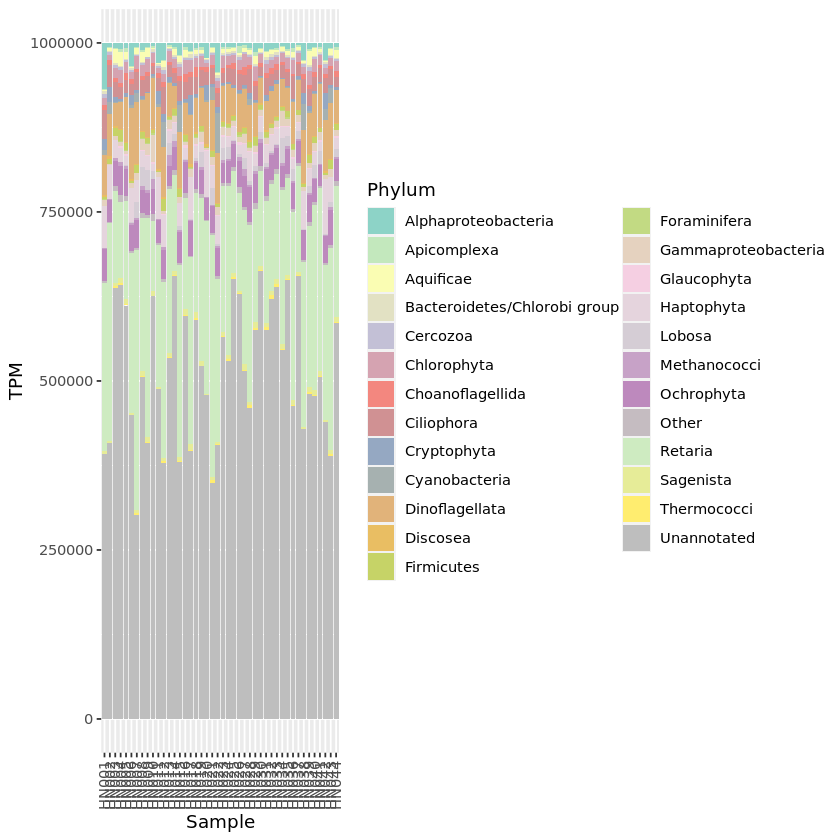

In [37]:
total_div_nt = all_salmon_nt %>% dplyr::mutate(Division = trimws(Division)) %>% 
    dplyr::group_by(Division) %>%
    dplyr::mutate(TotalTPM = sum(TPM,na.rm=T))

all_salmon_nt_rename = all_salmon_nt %>% dplyr::mutate(Division=trimws(Division)) %>% 
    dplyr::left_join(total_div_nt) %>%
    dplyr::mutate(DivisionSum = case_when(TotalTPM > 30000 ~ Division,
                                          TRUE ~ "Other"))

nt_annots = ggplot(all_salmon_nt_rename%>% dplyr::group_by(DivisionSum,Sample) %>%
          dplyr::summarize(TPM=sum(TPM))) + 
    geom_bar(aes(x = Sample, y = TPM, fill = DivisionSum),stat="identity")+ 
    scale_fill_manual(values = c(colorRampPalette(brewer.pal(12,"Set3"))(length(unique(all_salmon_nt_rename$DivisionSum))-1),"gray"),
                   name = "Phylum")+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=0.5))
nt_annots

`summarise()` has grouped output by
'DivisionSum'. You can override using
the `.groups` argument.


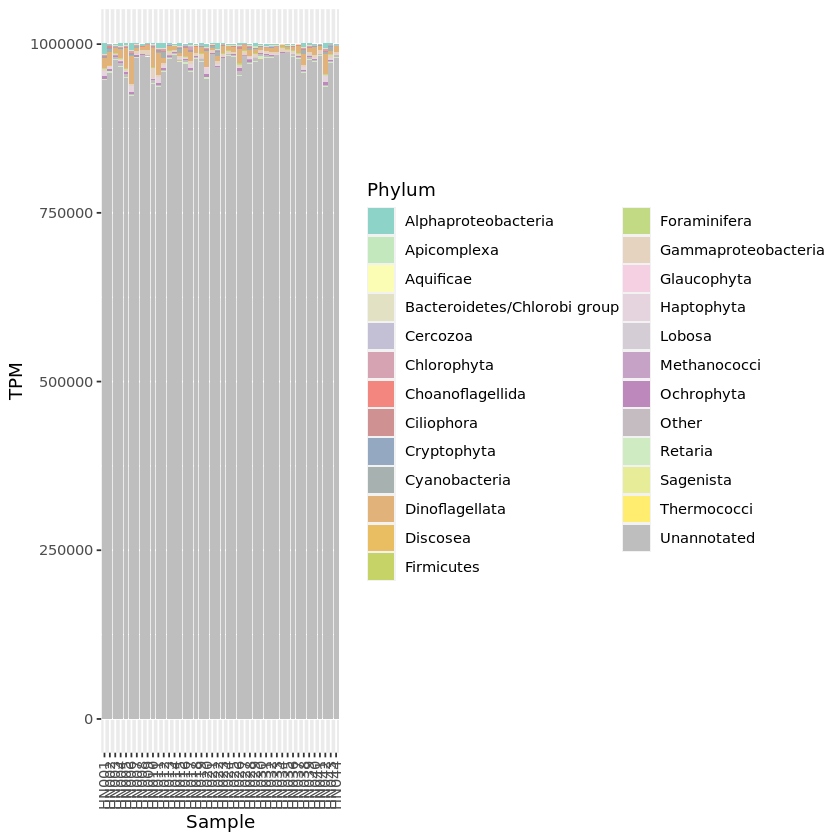

In [36]:
total_div_prot = all_salmon_prot %>% dplyr::group_by(Division) %>%
    dplyr::mutate(TotalTPM = sum(TPM))

all_salmon_prot_rename = all_salmon_prot %>% dplyr::mutate(Division = trimws(Division)) %>% #dplyr::left_join(total_div_nt) %>%
    dplyr::mutate(DivisionSum = case_when(Division %in% 
                                          (total_div_nt %>% dplyr::filter(TotalTPM > 30000))$Division ~ Division,
                                          TRUE ~ "Other"))

prot_annots = ggplot(all_salmon_prot_rename%>% dplyr::group_by(DivisionSum,Sample) %>%
          dplyr::summarize(TPM=sum(TPM))) + 
    geom_bar(aes(x = Sample, y = TPM, fill = DivisionSum),stat="identity")+ 
    scale_fill_manual(values = c(colorRampPalette(brewer.pal(12,"Set3"))(length(unique(all_salmon_prot_rename$DivisionSum))-1),
                                 "gray"),
                   name = "Phylum")+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=0.5))
prot_annots

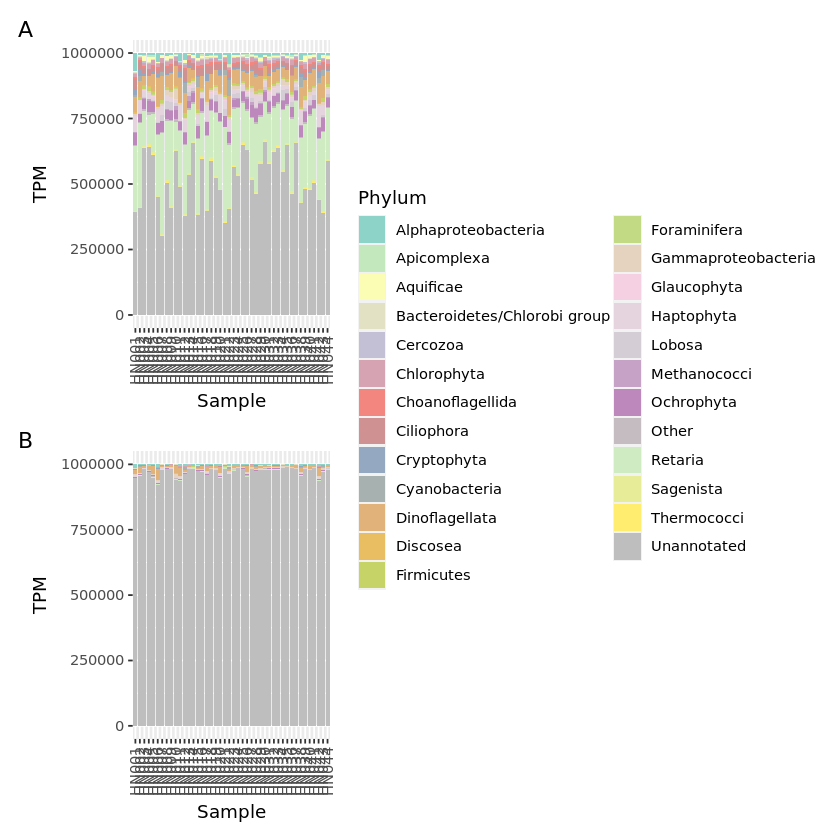

In [43]:
nt_annots/prot_annots + plot_layout(guides = "collect") & plot_annotation(tag_levels = "A")

ggsave("BATS_proportion_annotation.pdf",width=10,height=10,units="in")
ggsave("BATS_proportion_annotation.png",width=10,height=10,units="in",dpi=300)